# Artificial Intelligence and Machine Learning


## Unit II 

## Intro to Supervised Learning and k Nearest Neighbours (k-NN)

**Iacopo Masi**

In [1]:
from IPython.core.display import HTML

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
img[alt=regression] { width: "50%"; }
</style>
""")

## My own latex definitions
$\require{color}$

$$\def\mbf#1{\mathbf{#1}}$$
$$\def\bmf#1{\boldsymbol{#1}}$$
$$\def\bx{\mbf{x}}$$
$$\def\bv{\mbf{v}}$$
$$\def\bz{\mbf{z}}$$
$$\def\bmu{\bmf{\mu}}$$
$$\def\bsigma{\bmf{\Sigma}}$$
$$\def\Rd#1{\in \mathbb{R}^{#1}}$$

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

font = {'family' : 'Serif',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)


# Aux functions

def plot_grid(Xs, Ys, axs=None):
    ''' Aux function to plot a grid'''
    t = np.arange(Xs.size) # define progression of int for indexing colormap
    if axs:
        axs.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        axs.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        axs.axis('scaled') # axis scaled
    else:
        plt.plot(0, 0, marker='*', color='r', linestyle='none') #plot origin
        plt.scatter(Xs,Ys, c=t, cmap='jet', marker='.') # scatter x vs y
        plt.axis('scaled') # axis scaled
        
def linear_map(A, Xs, Ys):
    '''Map src points with A'''
    # [NxN,NxN] -> NxNx2 # add 3-rd axis, like adding another layer
    src = np.stack((Xs,Ys), axis=Xs.ndim)
    # flatten first two dimension
    # (NN)x2
    src_r = src.reshape(-1,src.shape[-1]) #ask reshape to keep last dimension and adjust the rest
    # 2x2 @ 2x(NN)
    dst = A @ src_r.T # 2xNN
    #(NN)x2 and then reshape as NxNx2
    dst = (dst.T).reshape(src.shape)
    # Access X and Y
    return dst[...,0], dst[...,1]


def plot_points(ax, Xs, Ys, col='red', unit=None, linestyle='solid'):
    '''Plots points'''
    ax.set_aspect('equal')
    ax.grid(True, which='both')
    ax.axhline(y=0, color='gray', linestyle="--")
    ax.axvline(x=0, color='gray',  linestyle="--")
    ax.plot(Xs, Ys, color=col)
    if unit is None:
        plotVectors(ax, [[0,1],[1,0]], ['gray']*2, alpha=1, linestyle=linestyle)
    else:
        plotVectors(ax, unit, [col]*2, alpha=1, linestyle=linestyle)

def plotVectors(ax, vecs, cols, alpha=1, linestyle='solid'):
    '''Plot set of vectors.'''
    for i in range(len(vecs)):
        x = np.concatenate([[0,0], vecs[i]])
        ax.quiver([x[0]],
                   [x[1]],
                   [x[2]],
                   [x[3]],
                   angles='xy', scale_units='xy', scale=1, color=cols[i],
                   alpha=alpha, linestyle=linestyle, linewidth=2)

# Recap previous lecture
- Recap on probability and Gaussian Distribution
- Maximum Likelihood Estimator (MLE)
- MLE with a single Gaussian
- Gaussian Mixture Model (GMM)
- Applications: Anomaly Detection and Data Generation

# Today's lecture
## Moving to Supervised Learning (Good news is that is easier)
### Non-parametric model
#### 1. $k$-Nearest Neighbours (Today)
#### 2. Decision Trees (Coming up)

# This lecture material is taken from
- [Cimi Book - Chapter 01](http://ciml.info/dl/v0_99/ciml-v0_99-ch01.pdf)
- [CSC411: Introduction to Machine Learning](https://www.cs.toronto.edu/~urtasun/courses/CSC411_Fall16/06_trees_handout.pdf)
- [Cornell ML course](http://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote02_kNN.html)
- [Prof. Olga Veksler ML course](https://www.csd.uwo.ca/~oveksler/Courses/Fall2015/CS9840/Lecture2_knn.pdf)

# Unsupervised Learning

**Objective and Motivation:** The goal of unsupervised learning is to find **hidden patterns** in unlabeled data. 

\begin{equation}
 \underbrace{\{\mathbf{x}_i\}_{i=1}^N}_{\text{known}} \sim \underbrace{\mathcal{D}}_{\text{unknown}}
\end{equation}


- Unlike in supervised learning, any data point is not paired with a label.

- As you can see the unsupervised learning problem is ill-posed (which hidden patterns?) and in principle more difficult than supervised learning.

- Unsupervised learning can be thought of as "finding structure" in the data.

# Supervised Learning

**Objective and Motivation:** The goal of supervised learning is to find **relations and associations** between pairs of data points paired with a label.


$$
 \underbrace{\{\bx_i,y_i\}_{i=1}^N}_{\text{known}} \sim \underbrace{\mathcal{D}}_{\text{unknown}}
$$


- Any data point $\bx \Rd{d}$ is paired with a label $y \Rd{1}$.
- We want to learn a function $h$ parametrized by $\theta$ that given $\bx$ predicts $y$ or else $h_{\theta} : \bx \rightarrow y$
- Note that the hypothesis (the model) can be either **parametric** or **non-parametric**.

<center>
<img width="30%" src="figs/learning.png" />
</center>

# Classification vs Regression

- The general settings are very similar. We want to learn a function $h$ parametrized by $\theta$ that given $\bx$ predicts $y$ or else $h_{\theta} : \bx \rightarrow y$
- **Regression:**
    - $y$ is a **continuous, real value** so $y \Rd{d}$ (e.g. predict the interest rate given as input some conditions of the financial market)
- **Classification**:
    - $y$ is a **categorical variable**. For example, classifying images of `hotdog vs non-hotdog` is the same as `0 vs 1`. In this case, we do **binary classification** if the categories are 2.
    - $y$ is a **categorical variable** with more than $N\gt2$ then it is **multi-class classification**.
    

 # Classification vs Regression
 
We will see soon that they are **two side of the same coin**
 
 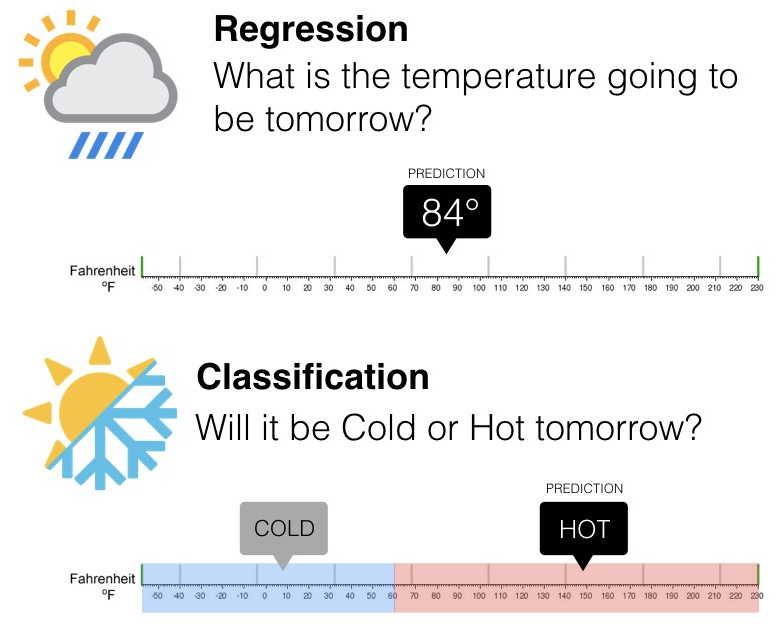
 
 [image credit](https://towardsdatascience.com/regression-or-classification-linear-or-logistic-f093e8757b9c)

# Parametric vs Non-Parametric
- If parametric, then the model information is "squeezed" into a set of **parameters** $\theta$
    - (e.g. $\theta=\bmu,\bsigma$ in the case of a single Gaussian)
- If non-parametric, then the way the model classifies/regresses a value is different and it is **NOT encoded** in some form of parameters $\theta$.

# Parametric vs Non-Parametric
- In a **parametric model**, the number of parameters is fixed with respect to the training size. We try to "squeeze" the information of the training set into the parameters useful for the task at hand (i.e. predicting $y$).
- In a **non-parametric model**, the (effective) number of parameters can grow with the training size.
    - Sometimes, we refer to non-parametric models as **instance-based learning**.
    - The reason for this name is because **learning amounts to simply storing training data.**
    - Test Instances are classified using `similar` training instances, but what is `similar`?

[\[Bishop: Pages 120-127\]](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)

# Non-Parametric Models
- Non-parametric models assume that the data distribution cannot be defined in terms of such a finite set of parameters $\theta$. But they can often be defined by assuming an infinite dimensional $\theta$.
    - The amount of information that $\theta$ can capture about the data $\mathcal{D}$ can grow as the amount of data grows. 
    - This makes them **more flexible and the advantage is that there is no training basically to do**!
    - The weakness is that **more expensive to store** _(what if we have a billion images?)_
    

# Two types of Non-Parametric Models

- $k$ Nearest-Neighbours
- Decision Trees

before moving to parametric models for the rest of the course.

#  Instance-based Learning assumptions
## such as $k$ Nearest-Neighbours

Embodies often sensible underlying assumptions:
- Output varies smoothly with input
- The data occupies a sub-space of the high-dimensional input space

# Formalizing the supervised learning problem

[Cimi - Chapter 01](http://ciml.info/dl/v0_99/ciml-v0_99-ch01.pdf)

Formalizing the notion of **learning** relationships between the data $\bx$ and the labels $y$.
- The performance of the learning algorithm should be measured on **$\colorbox{yellow}{unseen “test” data.}$**
- The way in which we measure performance should depend on the problem we are trying to solve (regression vs classification)
- There should be a **strong relationship between the data** that our algorithm sees at training time and the data it sees at test time **(i.i.d. assumptions)**

You will note that is **much better defined for supervised learning.**

# Learning = a) Lower ⬇︎ the cost $\mathcal{L}$ in training **AND** b)⬇︎ also in test

In order to accomplish a), let’s assume we have a **loss or cost** function:

$$\mathcal{L}(\underbrace{\hat{y}}_{pred.}, \underbrace{y}_{gt})\quad \text{where}\quad \hat{y}=h_{\theta}(\mathbf{x}) $$

- The job of $\mathcal{L}$ is to tell us how **“bad” a system’s prediction is, in comparison to the truth.**
- In particular, if $y$ is what is defined as **ground-truth value or label** and $\hat{y}$ is the machine prediction.
- You can view $\mathcal{L}$ as a measure of the system error over the training set. 

# Loss function

- Note that the **loss function** is something that you must decide on based on the goals of learning.
- There are multiple loss functions depending on what we want to achieve.

## Regression loss can be squared error

$$\mathcal{L}(\hat{y}, y) = (\hat{y} - y)^2 $$


## Regression loss can be absolute error

$$\mathcal{L}(\hat{y}, y) =~\mid\hat{y} - y\mid $$

## Binary Classification loss can be zero/one loss:

$$\mathcal{L}(y, \hat{y})= \begin{cases}0 & \text { if } y=\hat{y} \\ 1 & \text { otherwise }\end{cases}$$

## Probabilistic Modeling of Learning

**Objective and Motivation:** The goal of supervised learning is to find **relations and associations** between pairs of data points paired with a label.


$$
 \underbrace{\{\bx_i,y_i\}_{i=1}^N}_{\text{known}} \sim \underbrace{\mathcal{D}}_{\text{unknown}}
$$

- There is a probability distribution $\mathcal{D}$ over **input/output pairs** $p(\bx,y)$ 
- This is often called the data generating distribution.

A useful way to think about $\mathcal{D}$ is that it gives a high probability to reasonable $(\bx, y)$ pairs, and a low probability to unreasonable $(\bx, y)$ pairs.

- In case we do not have any prior on the shape of $\mathcal{D}$ (i.e. is it Gaussian?), we can treat each training sample:  $$\bx_i, y_i \sim p(\bx,y)$$  as a random sample from this distribution.
- The set of $\{\bx_i\}_i^N$ is said **training data**.
- We only see samples from $$\bx_i, y_i \sim p(\bx,y)$$

# Sample space $\Omega$

- **Quiz:** with is the sample space for $\bx_i \sim p(\bx,y)$ if $\bx$ is a `2x2` image that takes values in `[0,1,2]` with class labels `[hot, cold]`$

- Sample space is the set of all possible outcomes of $\bx$ times the possible values of $y$

- An image $\bx$ `HxW` that takes values `P=[0,1,2]`can be combined in $\mid P\mid^{(H\times W)}$ ways

- So all possible images are $3^4 = 81$ images that can take either label `hot` or `cold` thus

- `81x2` is the sample space of this toy problem joint distribution
- **What is the sample space of an IPhone camera for a binary classification problem?**

## Probabilistic Modeling of Learning
Based on this training data, we need to **induce** a function $f$ that maps new inputs $\bx$ to corresponding
prediction $\hat{y}$. 

The key property that $f$ should obey is that it should do well (as measured by $\mathcal{L}$) on future examples that are also drawn from $\mathcal{D}$.

Formally, it’s **expected loss $\epsilon$ over $\mathcal{D}$ should be as small as possible**:

$$\epsilon \triangleq \mathbb{E}_{(x, y) \sim \mathcal{D}}[\mathcal{L}(y, f(x))]=\sum_{(x, y)} \underbrace{\mathcal{D}(x, y)}_{\text{weight/prob}} \underbrace{\mathcal{L}(y, f(x))}_{\text{function}}$$

# Empirical Risk Minimization

- The difficulty in minimizing our expected loss is that we don't know what $\mathcal{D}$ is! 
- All we have access to is some training data sampled from it! 
- The training data consists of $N$-many input/output pairs, $\left(x_{1}, y_{1}\right),\left(x_{2}, y_{2}\right), \ldots,\left(x_{N}, y_{N}\right) .$

# Empirical Risk Minimization

$$
\begin{array}{rlr}
\mathbb{E}_{(x, y) \sim D}[\mathcal{L}(y, f(x))] & =\sum_{(x, y) \in D}[D(x, y) \mathcal{L}(y, f(x))] & \text {def. of expect. of function} \mathop{\mathbb{E}}[f(\bx)] = \sum p(\bx) f(\bx) \\
& =\sum_{n=1}^{M}\left[D\left(x_{n}, y_{n}\right) \mathcal{L}\left(y_{n}, f\left(x_{n}\right)\right)\right] & D \text { is discrete and finite}, M=\text{all possible samples} \\
& \approx \sum_{n=1}^{N}\left[\frac{1}{N} \mathcal{L}\left(y_{n}, f\left(x_{n}\right)\right)\right] & \textbf{law of large numbers }, N=\text{number of training points} \\
& =\frac{1}{N} \sum_{n=1}^{N}\mathcal{L}\left(y_{n}, f\left(x_{n}\right)\right) & \text { rearranging terms }
\end{array}
$$

# Empirical Risk Minimization (ERM)

- Minimizes the average loss function over the training set with equal probability to each sample
- If you take the weighted average instead, it is a way to saying this sample is more probably or put more emphasis on this sample.
- Works under the **weak law of large numbers** and approximiation vanishes when $N \mapsto \infty$
$$\epsilon = \frac{1}{N} \sum_{n=1}^{N}\mathcal{L}\left(y_{n}, f\left(x_{n}\right)\right) $$

# Watch out: Spurious Correlations

- In a famous--if possibly apocryphal--example from the 1970s, the US Government wanted to **train a classifier to distinguish between US tanks and Russian tanks.**

- They collected a training and test set and managed to **build a classifier with nearly 100% accuracy on that data.**

- **But when this classifier was run in the “real world”, it failed miserably.**

# Watch out: Spurious Correlations

It had not, in fact, learned to distinguish between US tanks and Russian tanks, **but rather just between clear photos and blurry photos.**

In this case, there was a $\colorbox{yellow}{\textbf{bias}}$ in the training data (due to how the training data was collected) that caused the learning algorithm to learn something other than what we were hoping for.

<img width='70%' src="figs/spurious_corr.png" />

[Taken from this article](https://arxiv.org/pdf/2004.07780.pdf)

# ERM and Its Limits: Bias-Variance Trade-off

$$\colorbox{yellow}{$\epsilon = \frac{1}{N} \sum_{n=1}^{N}\mathcal{L}\big(y_{n}, f\left(x_{n}\right)\big)$
}$$

The error of an ML system can be always decomposed into **two parts**:
- **Bias Error**
- **Variance Error**

# Bias-Variance Trade-off

# BIAS-Variance Trade-off
- The **bias error** is produced by weak assumptions in the learning algorithm
    - **High bias** can cause an algorithm to **miss the relevant relations between features and target outputs** 
    - Problem known as `underfitting`. Solution: increase the complexity/expressiveness of your ML algorithm!

# Bias-VARIANCE Trade-off

- The **variance** is an error produced by an **oversensitivity to small fluctuations in the training set**
    - High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs 
    - Problem known as `overfitting`. Solution: decrease the model complexity or add strong regularization.

# Bias-Variance Tradeoff as Dartboard


<center>
    <img width="40%" src="figs/bias_variance.png" />
<center/>

# Error in function of model complexity
<center>
<img width="60%" src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Bias_and_variance_contributing_to_total_error.svg" />
<center/>

# Over or Under Fitting

<center>
<img width="60%" src="figs/over_under_fit.png" />
</center>

# $k$-Nearest Neighbours

#### Non-parametric models

# Quiz: how do you classify the "? question mark"? Plus or a minus?


- Quick tip on what happens in the machine: the position `x,y` encode the features; the `+/-` encodes the class labels
- We want to achieve: $(x,y) \mapsto \pm$?
- **Binary Classification**
<center>
<img width='30%' src="figs/knn_classifyit.svg" />
    <center/>

# Assumptions of a ML algorithm (No free lunch theorem)

- There is **NO universal method** that will work for **all the data**
- It is important to know the assumptions of each method so that you can apply it under the right settings in your problem

# Assumptions of $k$-NN

- One reason why you might have thought that is that you believe that **$\colorbox{yellow}{the label for an example should be similar to the label of nearby points.}$**  

- Another way of saying the same is: **The output varies smoothly wrt to the input**

- This is an example of a new form of **inductive bias** or else **assumption that you make before the data arrives**.

- The **nearest neighbor (NN)** classifier is built upon this insight.

# Nearest Neighbour

- At training time, we simply **store the entire training set along with labels**
- At test time, we get a test example $\hat\bv$.  
- To predict its label, we find the training example $\bx$ that is **most similar** to $\hat\bv$.

# What's "Most Similar"?

We have to formalize **"most similar"**:
- We have the notion of **a point in a vector-space.**
- We have the notion of **distance between data points** (we can assume euclidean for now aka $\ell_2$)

**Most similar $\rightarrow$ minimum distance in the vector space**: we find the training example $\bx_i$ such that  $$i^*=\arg\min_{i\in\mathcal{X}} d(\bx,\hat\bv).$$
- Since $\bx_i$ is a training example, it has a corresponding label, $y$.  
- We predict that the label of $\hat\bv$ is also $y$.

# Nearest Neighbour

Input is the datapoint $\bv$;    $\mathcal{D} = \{(\bx_1,y_1)\ldots,(\bx_n,y_n)\}$ is the training set

Algorithm:
1. Find example $\left(\mathbf{x}^{*}, t^{*}\right)$ _(from  $\mathcal{D}$)_ closest to the test instance $\bv$. That is:
$$
\mathbf{x}^{*}=\underset{\mathbf{x}_{i} \in \mathcal{D}}{\operatorname{argmin}} \operatorname{d}\left(\mathbf{x}_{i}, \bv\right)
$$

where $\operatorname{d}(\cdot,\cdot)$ is a suitable distance metric.

2. Output $y=t^{*}$

# Another quiz is coming and we will be using NN to classify!

# Quiz: Let us use NN to classify!
<center>
<img width='25%' src="figs/knn_classifyitbad.svg" /><center/>

Since the nearest neighbor algorithm only looks at the *single* nearest neighbor, **it cannot consider
the ``preponderance of evidence`` that this point should probably actually be a negative example.**  It will make an unnecessary error.

# NN is sensitive to class-label noise

- We can improve by performing **smoothing**. 
- Why just select a single **neighbour**?
- Indeed we see that if we relax and look at its 3 NN we have **2 minus vs 1 plus.**
- By **$\underline{\text{voting}}$  over the k-NN**, we get the correct class.

<center>
<img width='25%' src="figs/knn_classifyitbad.svg" /></center>


# Ambigous cases based on the distance and neighbours
<br/>
<center>
<img src="figs/ambigous.png" width="30%"/>
</center>

# The set of $k$-Nearest Neighbours -  Definition
- Denote the set of the $k$ nearest neighbors of $\mathbf{x}$ as $S_{\mathbf{x}}$. Formally $S_{\mathrm{x}}$ is defined as $S_{\mathrm{x}} \subseteq D$ s.t. $\left|S_{\mathrm{x}}\right|=k$ and $\forall\left(\mathbf{x}^{\prime}, y^{\prime}\right) \in D~\backslash~S_{\mathrm{x} \prime}$

$$
\operatorname{dist}\left(\mathbf{x}, \mathbf{x}^{\prime}\right) \geq \max _{\left(\mathbf{x}^{\prime \prime}, y^{\prime \prime}\right) \in S_{\mathbf{x}}} \operatorname{dist}\left(\mathbf{x}, \mathbf{x}^{\prime \prime}\right)
$$



- (i.e. every point in $D$ but not in $S_{\mathrm{x}}$ is at least as far away from $\mathbf{x}$ as the furthest point in $S_{\mathbf{x}}$ ). 

- We can then define the classifier $h(\cdot)$ as a function returning the most common label in $S_{\mathrm{x}}$:

$$
h(\mathbf{x})=\operatorname{mode}\left(\left\{y^{\prime \prime}:\left(\mathbf{x}^{\prime \prime}, y^{\prime \prime}\right) \in S_{\mathbf{x}}\right\}\right)
$$

# $k$-Nearest Neighbour

Input is the datapoint $\bv$;  $~~~\mathcal{D} = \{(\bx_1,y_1)\ldots,(\bx_n,y_n)\}$ is the training set

Algorithm: 
1. We find first the set of $k$ Nearest Neighbour to $\bv$ called $S_{\mathrm{v}}$.

 Formally $S_{\mathrm{v}}$ is defined as $S_{\mathrm{v}} \subseteq \mathcal{D}$ s.t. $\left|S_{\mathrm{v}}\right|=k$ and $\forall\left(\mathbf{x}^{\prime}, y^{\prime}\right) \in D \backslash S_{\mathrm{v} \prime}$
 
$$ \colorbox{yellow}{$\operatorname{d}\left(\mathbf{v}, \mathbf{x}^{\prime}\right) \geq \max _{\left(\mathbf{x}^{\prime \prime}, y^{\prime \prime}\right) \in S_{\mathbf{v}}} \operatorname{dist}\left(\mathbf{v}, \mathbf{x}^{\prime \prime}\right)$}
$$

(i.e. every point in $D$ but not in $S_{\mathrm{v}}$ is at least as far away from $\mathbf{v}$ as the furthest point in $S_{\mathbf{v}}$ ).

`Technically this part is implemented simply as sorting and choosing top-K in a brute-force approach`

2. Assign the label to $\bv$ as most frequent element in the labels of $S_{\mathrm{v}}$ That is:

$$
y^{*}=\mbf{\operatorname{mode}}\left(\left\{y^{\prime \prime}:\left(\mathbf{x}^{\prime \prime}, y^{\prime \prime}\right) \in S_{\mathbf{v}}\right\}\right) \qquad \text{for classification}
$$

the **mode** of a distribution recovers the most frequent element.

**🛠 Hyperparam: How do we choose $k$?**

# The impact of hyper-parameter $k$

<center>
<img src="figs/ambigous.png" width="30%"/>
</center>

# Which distance metric to use?

## There is a family of distances: Minkowski distance

The k-nearest neighbor classifier fundamentally relies on a **distance metric**. <ins>The better that metric reflects label similarity, the better the classification will be</ins>. The most common choice is one over the family of distances defined by the **Minkowski distance**:

$$
\operatorname{dist}(\mathbf{x}, \mathbf{z};p)=\left(\sum_{r=1}^{d}\left|x_{r}-z_{r}\right|^{p}\right)^{1 / p}
$$

This distance definition is pretty general and contains many well-known distances as special cases. Can you identify the following candidates?
1. $p=1$ :
2. $p=2$ :
3. $p \rightarrow \infty$

## Cosine distance

If you want to measure only the angle you can use the **cosine distance**.

## What is a good distance here to perform classification (color is the class) ?



<input type="checkbox" disabled > L1 distance (Manhattan)

<input type="checkbox" disabled > L2 distance (Euclidean)

<input type="checkbox" disabled > L_inf distance (Max of abs value)

<input type="checkbox" disabled> Cosine distance

<input type="checkbox" disabled> Mahalanobis distance


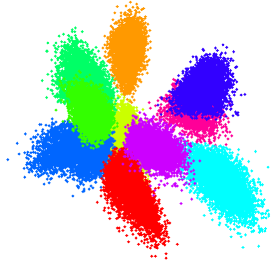

## What is a good distance here to perform classification (color is the class) ?



<input type="checkbox" disabled > L1 distance (Manhattan)

<input type="checkbox" disabled > L2 distance (Euclidean)

<input type="checkbox" disabled > L_inf distance (Max of abs value)

<input type="checkbox" disabled checked> **Cosine distance** (features of the same classes are almost on the same line)

<input type="checkbox" disabled checked> **Mahalanobis distance** (but requires to estimate covariance matrices)

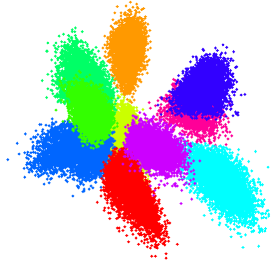

# The impact of hyper-parameter $k$

2. Assign the label to $\bv$ as most frequent element in the labels of $S_{\mathrm{v}}$. That is:

$$
y^{*}=\mbf{\operatorname{mode}}\left(\left\{y^{\prime \prime}:\left(\mathbf{x}^{\prime \prime}, y^{\prime \prime}\right) \in S_{\mathbf{v}}\right\}\right) \qquad \text{for classification}
$$

the **mode** of a distribution recovers the most frequent element.

**🛠 Hyperparam: How do we choose $k$?**

# The impact of hyper-parameter $k$

<center>
<img src="figs/ambigous.png" width="30%"/>
</center>

# How do we choose $k$?
- $k=1$ is the NN algorithm and may suffer from **overfitting**. You just based your decision on too little information.
- $k \gg 1$ you may end up with good performance (you smooth out the result, i.e. impose regularization)
- if you have binary classification, $k$ better be **odd** (why is that?)

- Now let's think what happens when $k=|\mathcal{D}|$? i.e. $k$ is equal to the number of datapoints!?

- if $k=|\mathcal{D}|$ then we **<ins>underfit</ins>** and always **predict the majority class in $\mathcal{D}$.**

## Best constant predictor

- if $k=|\mathcal{D}|$ then we underfit and always **predict the majority class in $\mathcal{D}$.**
- You can think of the best constant predictor as a lazy algorithm that just counts the frequency of labels in the data and, without EVEN looking at the input, predicts the most frequent label.

# Yes, but how do we choose $k$?

- We can use **cross-validation** to find k
- The rule of thumb is `k < sqrt(N)`, where N is the number of training examples (idea: if N is small, k should be small but; if N is large K should be increased but not too much; sqrt function increases as N when N is small; for large N the value is kept much lower than N).

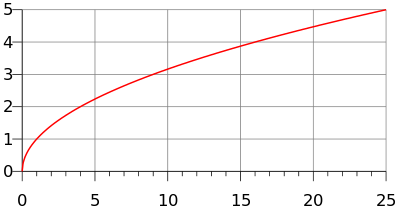

# k-NN decision boundary and demo

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors, datasets
# import some data to play with
iris = datasets.load_iris()
# we only take the first two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = iris.data[:, :2] # Nx2 
y = iris.target      # Nx1

# The data

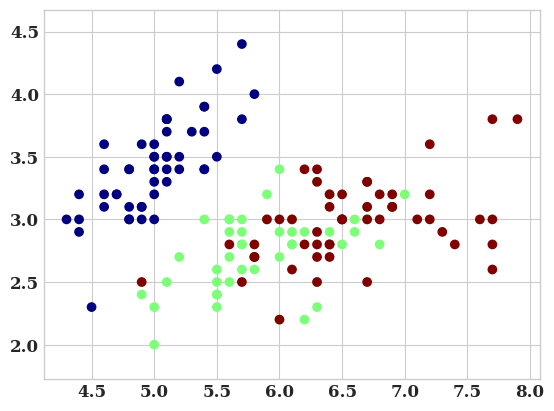

In [4]:
plt.scatter(*X.T, c=y, cmap='jet');
plt.axis('equal');

# Decision boundaries by varying $k$

/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

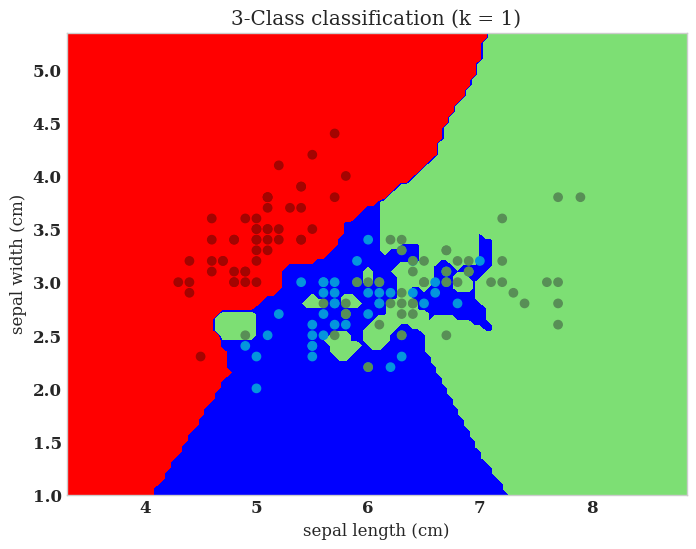

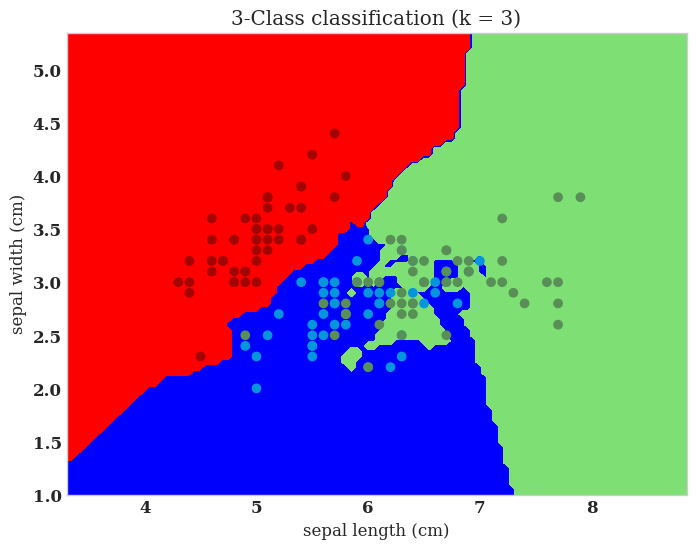

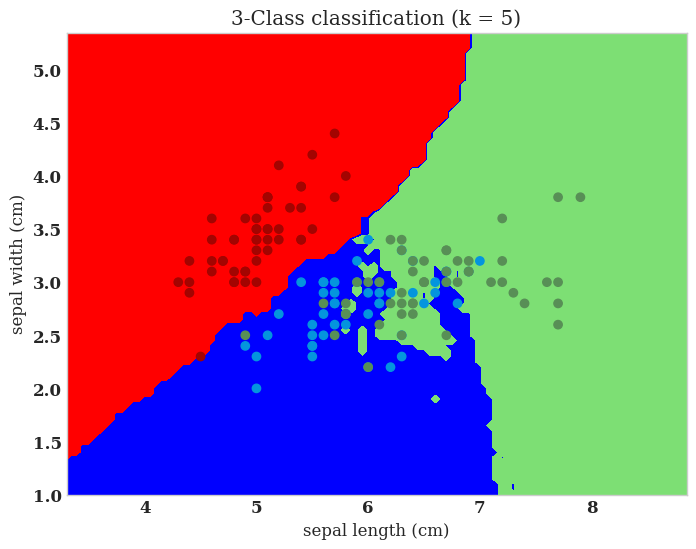

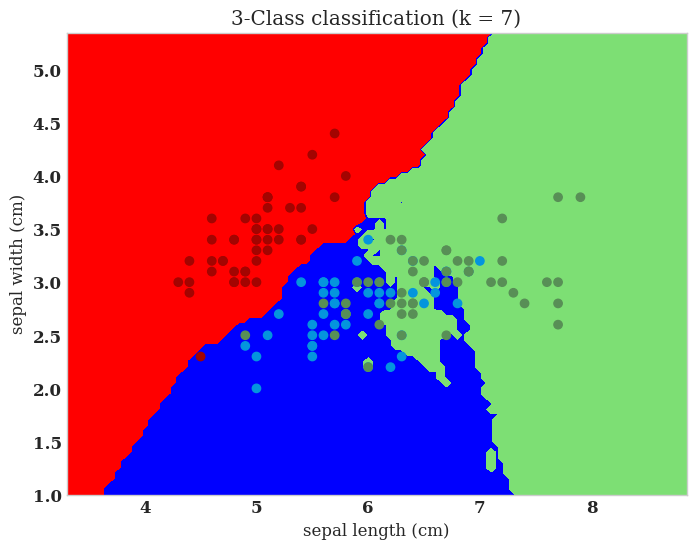

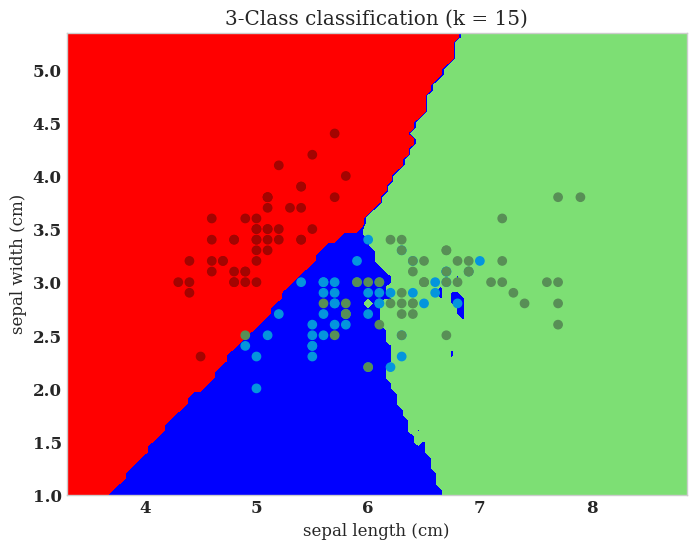

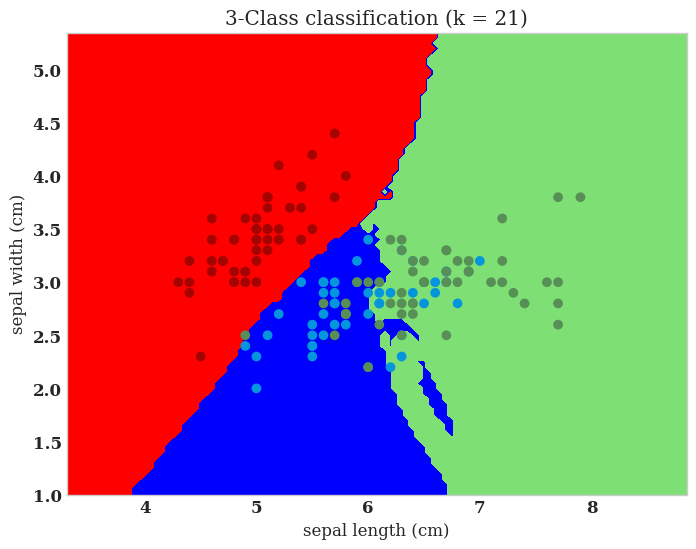

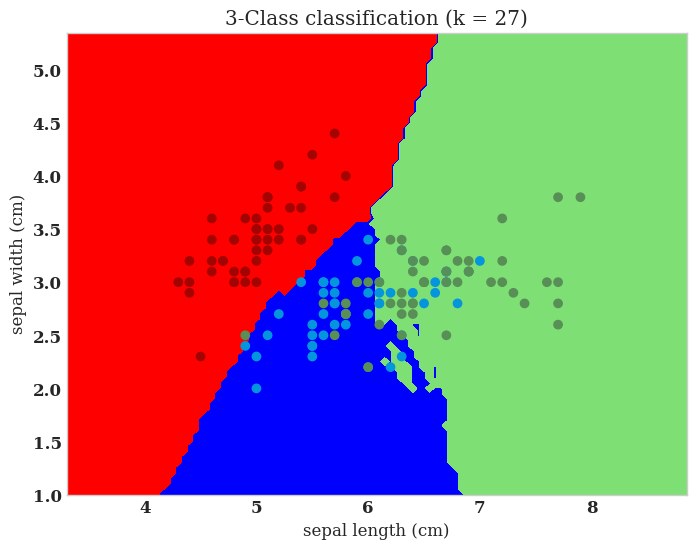

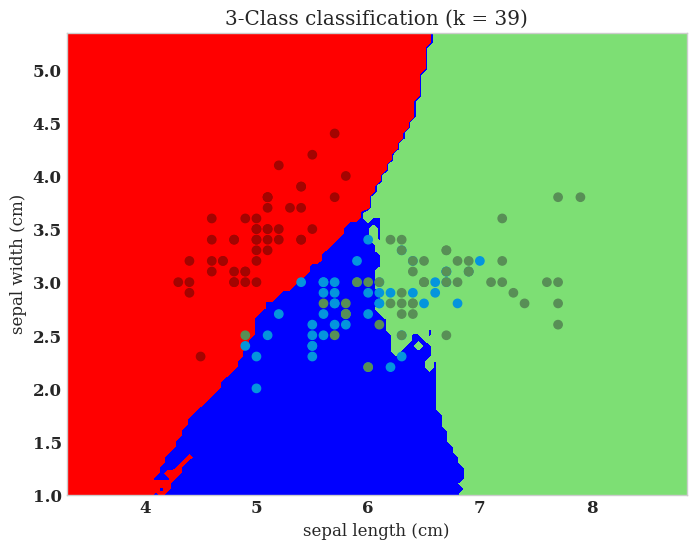

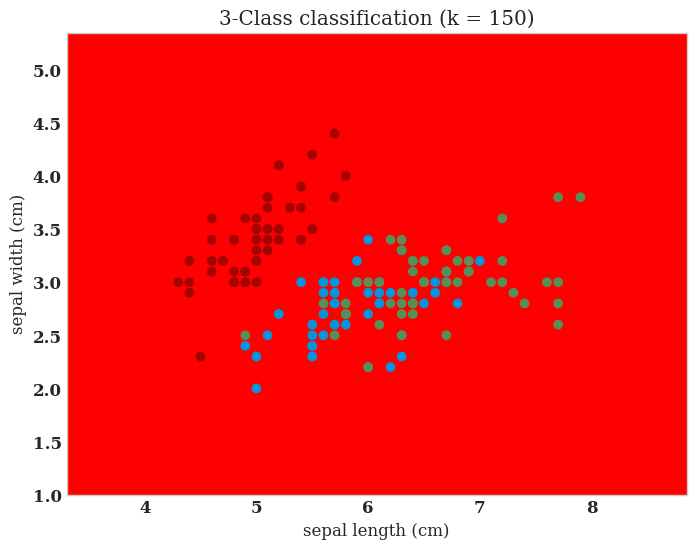

In [5]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

###################################################
h = 0.05  # step size in the mesh
##################################################

# Create color maps
cm = ListedColormap(["#a30401", "#0495dd", "#588f56"])
cm_bright = ListedColormap(["#FF0000", "#0000FF", "#7ddf74"])


for n_neighbors in [1, 3, 5, 7, 15, 21, 27, 39, X.shape[0]]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(
        n_neighbors, weights="uniform", algorithm='brute', p=2)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cm_bright)

    # Plot also the training points
    plt.scatter(
        x=X[:, 0],
        y=X[:, 1],
        c=y,
        cmap=cm,
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "3-Class classification (k = %i)" % (n_neighbors)
    )
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])
plt.show()

/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

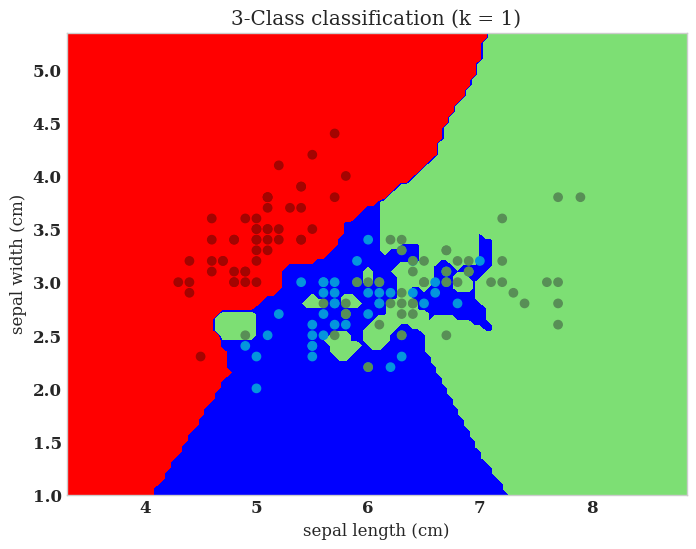

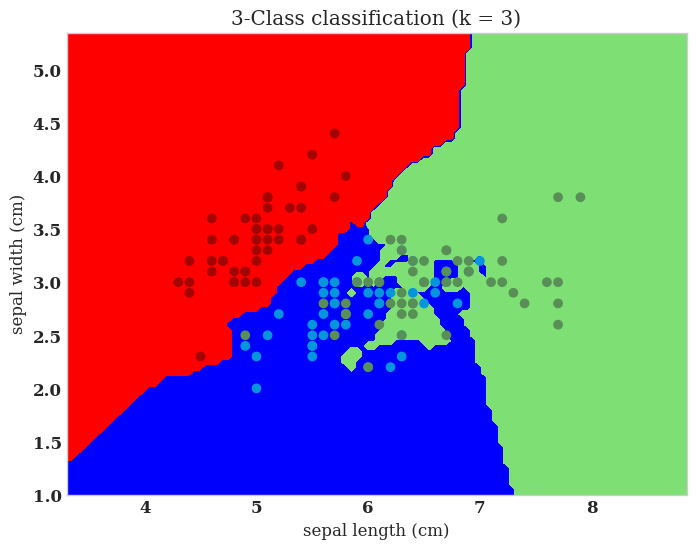

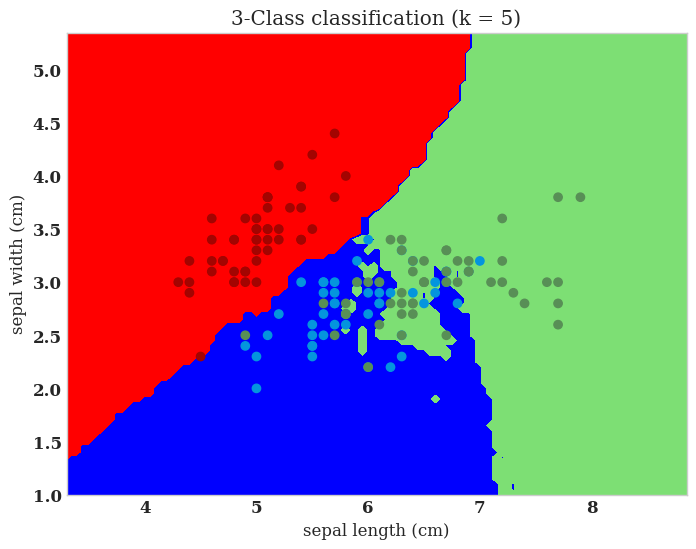

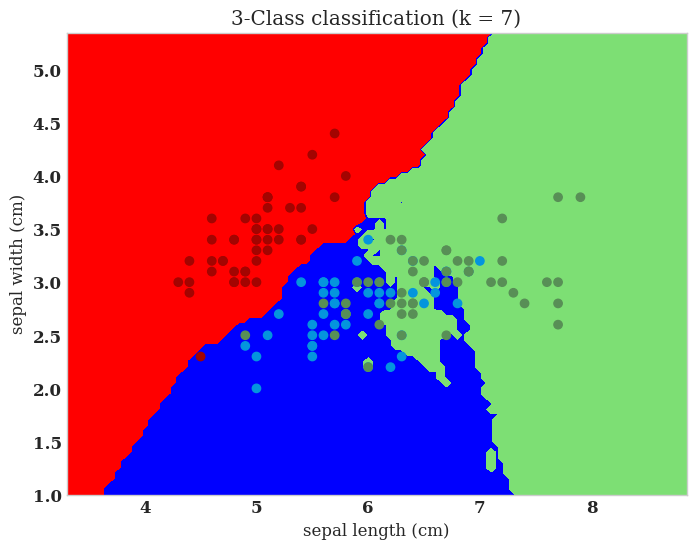

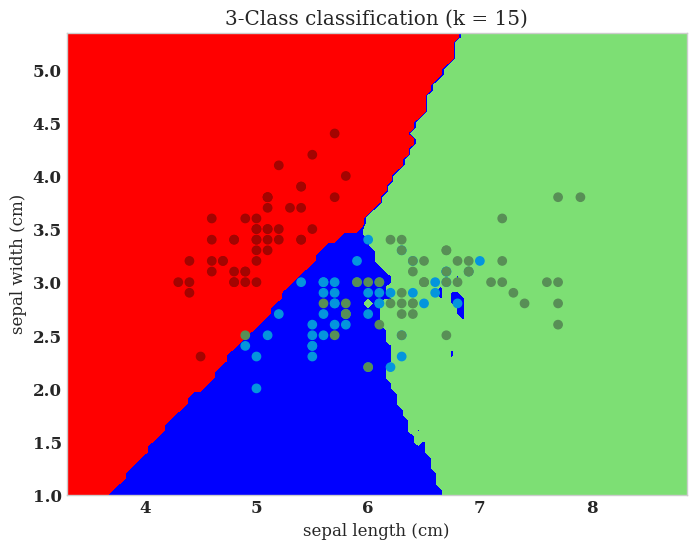

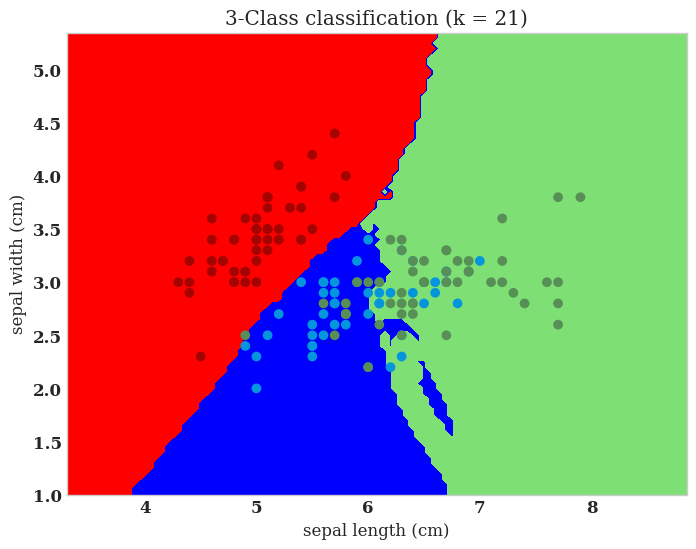

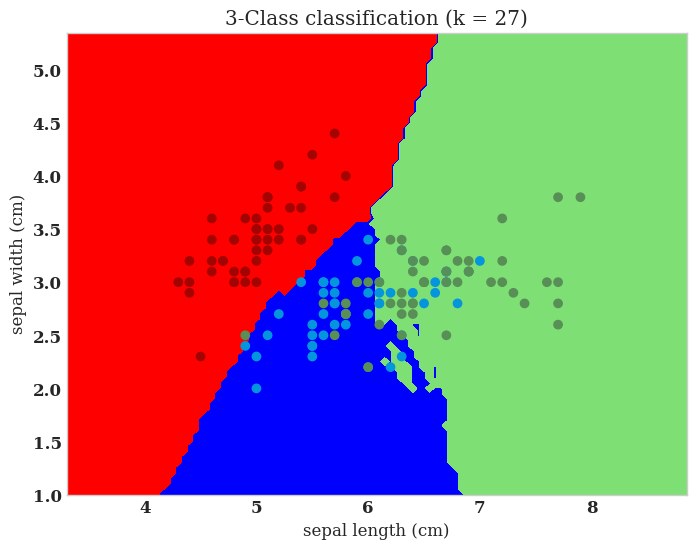

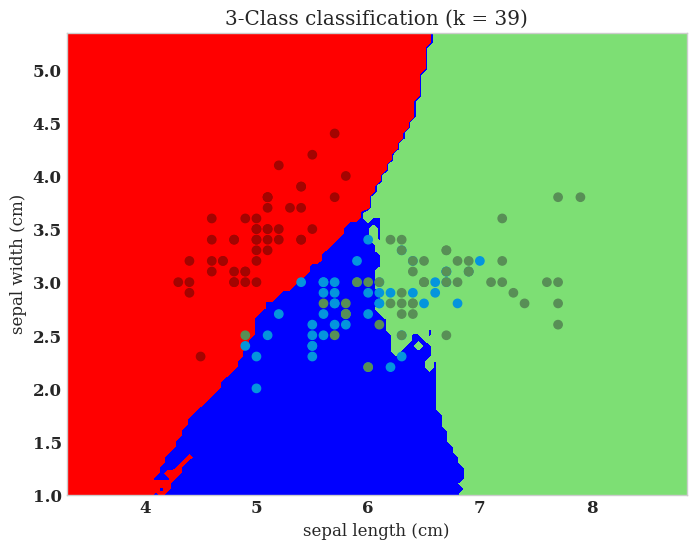

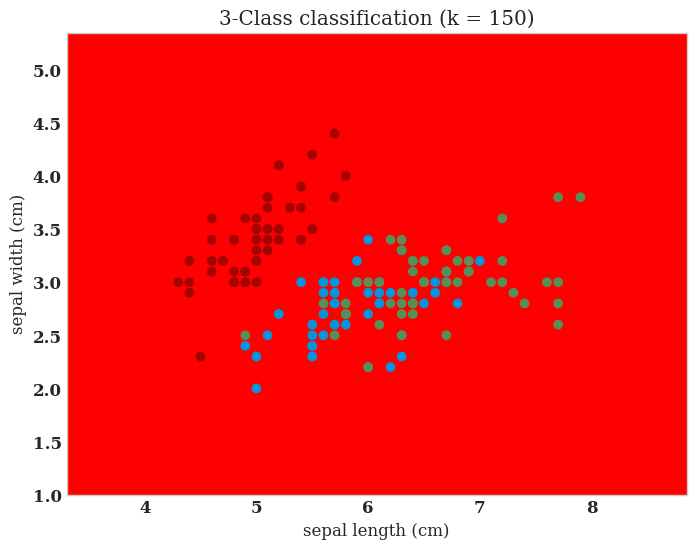

In [6]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

###################################################
h = 0.05  # step size in the mesh
##################################################

# Create color maps
cm = ListedColormap(["#a30401", "#0495dd", "#588f56"])
cm_bright = ListedColormap(["#FF0000", "#0000FF", "#7ddf74"])


for n_neighbors in [1, 3, 5, 7, 15, 21, 27, 39, X.shape[0]]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(
        n_neighbors, weights="uniform", algorithm='brute', p=2)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cm_bright)

    # Plot also the training points
    plt.scatter(
        x=X[:, 0],
        y=X[:, 1],
        c=y,
        cmap=cm,
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "3-Class classification (k = %i)" % (n_neighbors)
    )
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])

plt.show()

# Decision boundaries by varying distance

/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

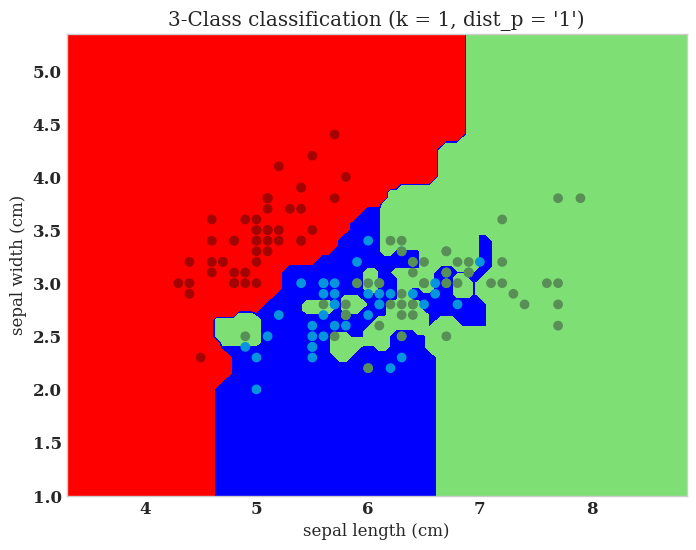

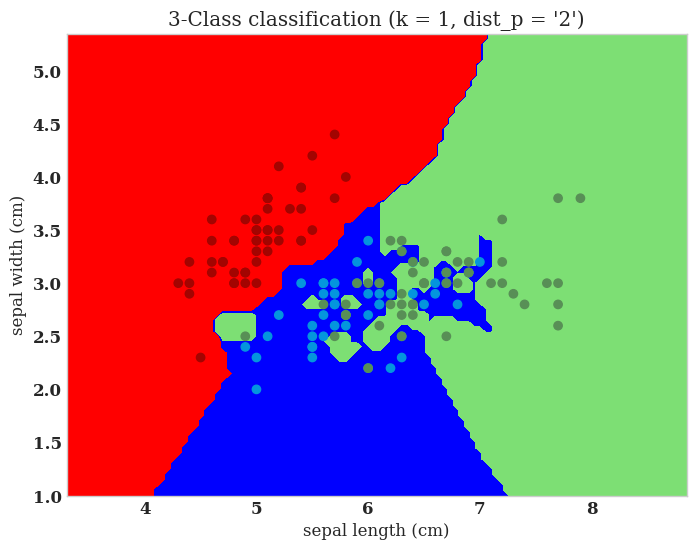

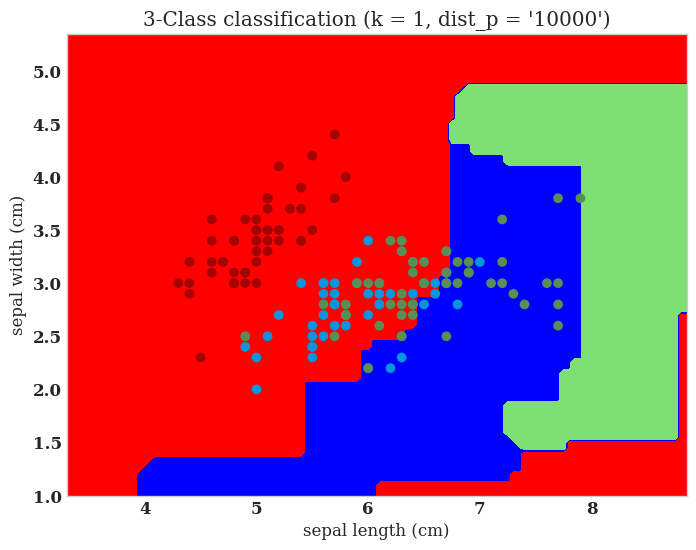

In [7]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

###################################################
h = 0.05  # step size in the mesh
n_neighbors = 1
##################################################

# Create color maps
cm = ListedColormap(["#a30401", "#0495dd", "#588f56"])
cm_bright = ListedColormap(["#FF0000", "#0000FF", "#7ddf74"])


for dist in [1, 2, 10000]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(
        n_neighbors, weights="uniform", algorithm='brute', p=dist)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cm_bright)

    # Plot also the training points
    plt.scatter(
        x=X[:, 0],
        y=X[:, 1],
        c=y,
        cmap=cm,
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "3-Class classification (k = %i, dist_p = '%i')" % (n_neighbors, dist)
    )
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])

plt.show()

/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

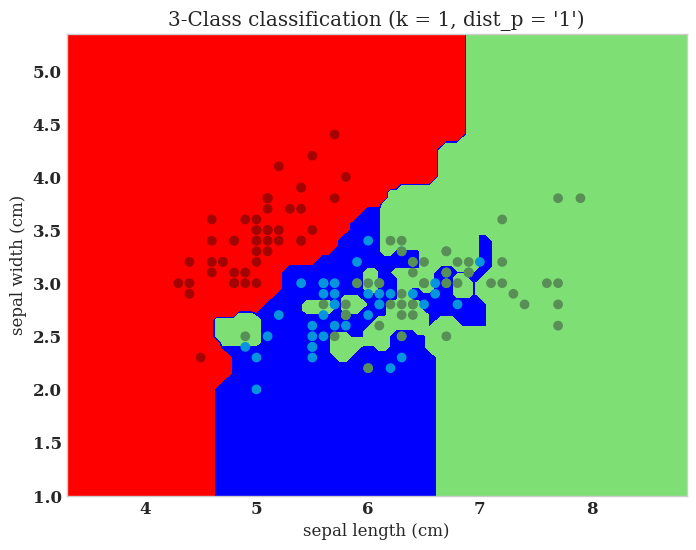

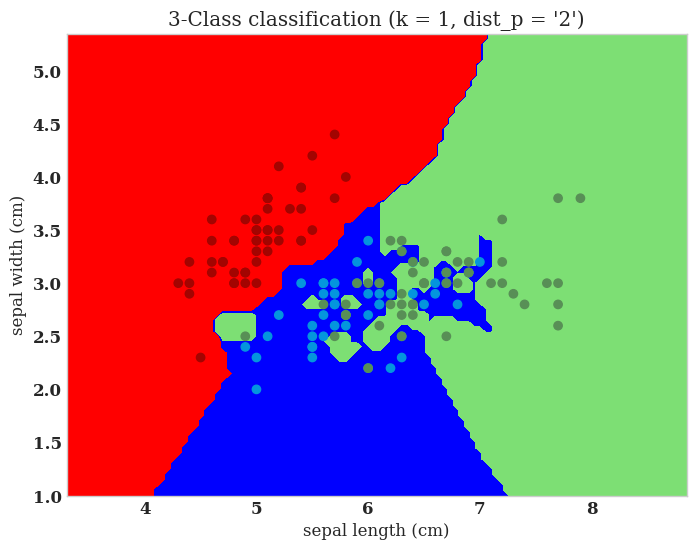

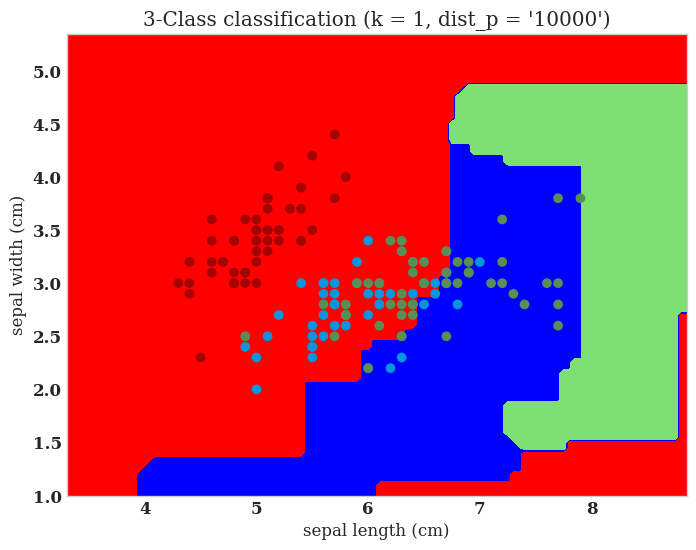

In [8]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

###################################################
h = 0.05  # step size in the mesh
n_neighbors = 1
##################################################

# Create color maps
cm = ListedColormap(["#a30401", "#0495dd", "#588f56"])
cm_bright = ListedColormap(["#FF0000", "#0000FF", "#7ddf74"])


for dist in [1, 2,10000]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(
        n_neighbors, weights="uniform", algorithm='brute', p=dist)
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cm_bright)

    # Plot also the training points
    plt.scatter(
        x=X[:, 0],
        y=X[:, 1],
        c=y,
        cmap=cm,
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "3-Class classification (k = %i, dist_p = '%i')" % (n_neighbors, dist)
    )
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])

plt.show()

# $k$-NN has irregular and non-linear decision boundaries

/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

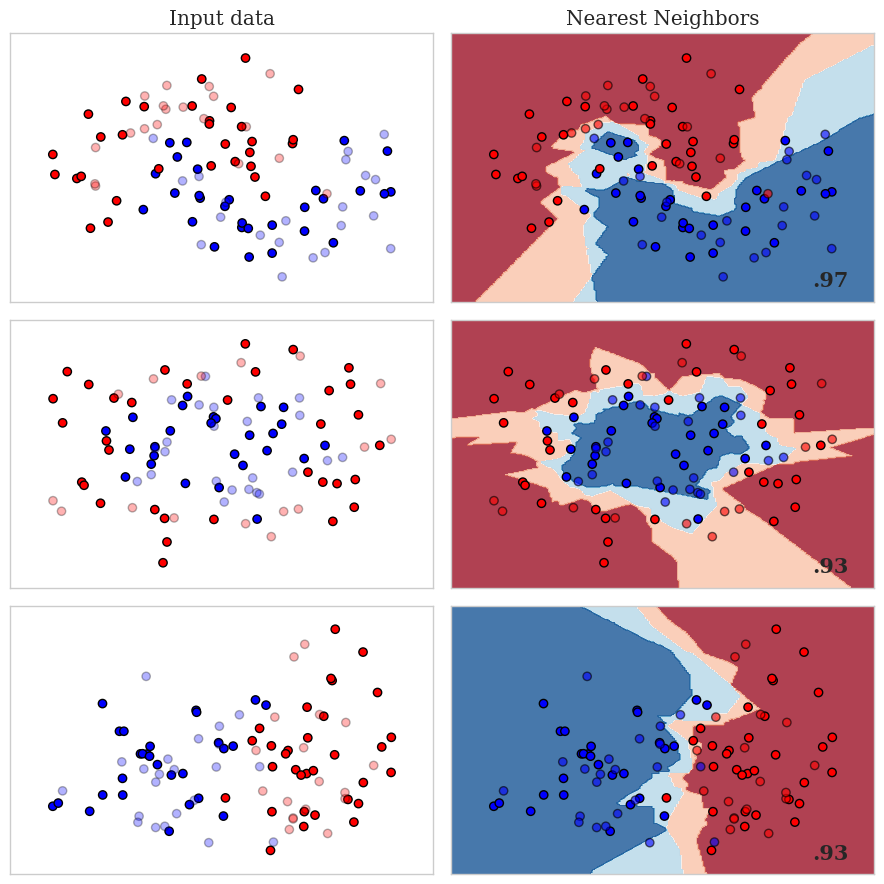

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier


h = 0.02  # step size in the mesh

names = [
    "Nearest Neighbors",
]

classifiers = [
    KNeighborsClassifier(3),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(9, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.3, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

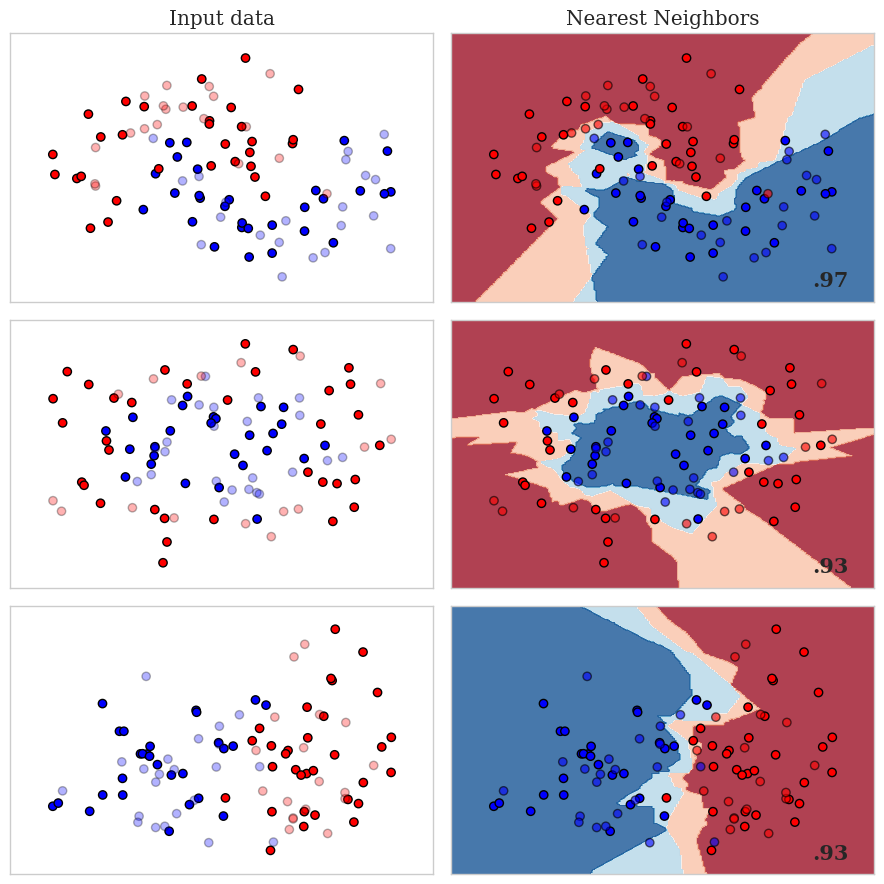

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier


h = 0.02  # step size in the mesh

names = [
    "Nearest Neighbors",
]

classifiers = [
    KNeighborsClassifier(3),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(9, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.3, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

# $k$-NN Issues and Remedies

#### Hint: Achilles' heel is the distance

# First issue: the feature range matters!

- So far we assumed we use **Euclidean distance** to find the nearest neighbor but:

$$ d(\bx,\bv) = \sqrt{\sum_{i=1}^D  (x_i - v_i)^2} \qquad \text{with}~~\bx,\bv \in \mathbb{R}^D$$

- Euclidean distance treats each feature as **equally important** (each axis in the vector)
- However **some features (dimensions) may be much more discriminative than other features**

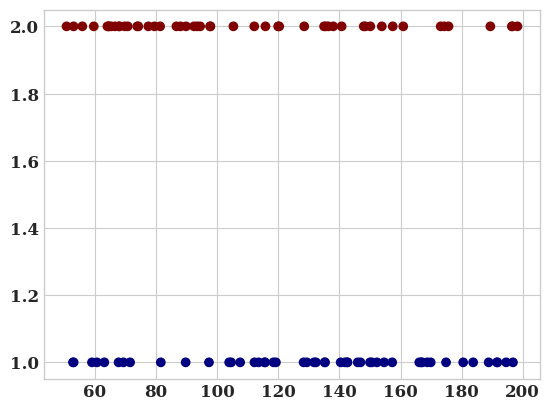

In [11]:
np.random.seed(0)
N_samples = 50
# samples points for class 1
X_1 = np.random.uniform(50, 200, N_samples)
X_1 = np.vstack((X_1, (1,)*N_samples))
# samples points for class 2
X_2 = np.random.uniform(50, 200, N_samples)
X_2 = np.vstack((X_2, (2,)*N_samples))
X = np.concatenate((X_1, X_2))
# data
X = np.concatenate((X_1, X_2), axis=1)
# labels
labels = X[1, ...]
# Plot also the training points
plt.scatter(
    x=X[0, ...],
    y=X[1, ...],
    c=labels,
    cmap='jet',
)
# Code below wants Nx2
X = X.T

# Let's try to see what happens with $k$=1 so we make sure we fit well (overfit) the data

/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


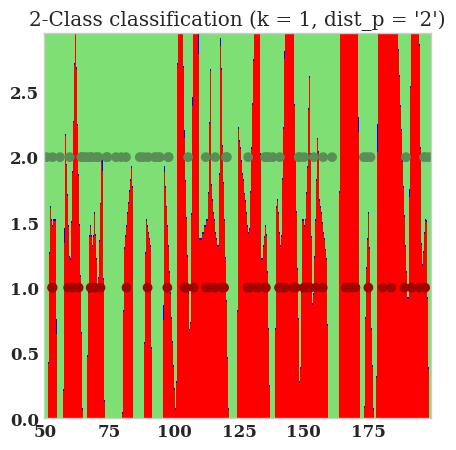

In [12]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

###################################################
h = 0.05  # step size in the mesh
n_neighbors = 1
##################################################

# Create color maps
cm = ListedColormap(["#a30401", "#0495dd", "#588f56"])
cm_bright = ListedColormap(["#FF0000", "#0000FF", "#7ddf74"])


for dist in [2]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(
        n_neighbors, weights="uniform", algorithm='brute', p=dist)
    clf.fit(X, labels)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, Z, cmap=cm_bright)

    # Plot also the training points
    plt.scatter(
        x=X[:, 0],
        y=X[:, 1],
        c=labels,
        cmap=cm,
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "2-Class classification (k = %i, dist_p = '%i')" % (n_neighbors, dist)
    )
plt.show()

/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


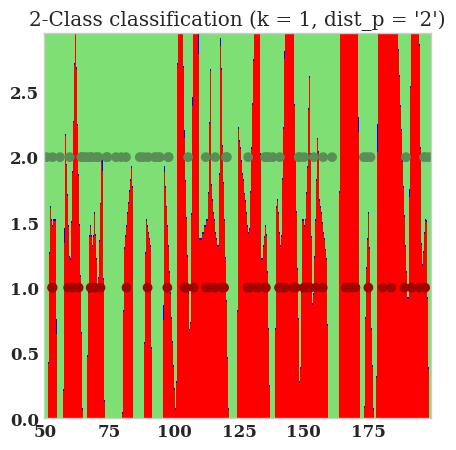

In [13]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

###################################################
h = 0.05  # step size in the mesh
n_neighbors = 1
##################################################

# Create color maps
cm = ListedColormap(["#a30401", "#0495dd", "#588f56"])
cm_bright = ListedColormap(["#FF0000", "#0000FF", "#7ddf74"])


for dist in [2]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(
        n_neighbors, weights="uniform", algorithm='brute', p=dist)
    clf.fit(X, labels)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, Z, cmap=cm_bright)

    # Plot also the training points
    plt.scatter(
        x=X[:, 0],
        y=X[:, 1],
        c=labels,
        cmap=cm,
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "2-Class classification (k = %i, dist_p = '%i')" % (n_neighbors, dist)
    )
plt.show()

# Who believes this is a good separation?

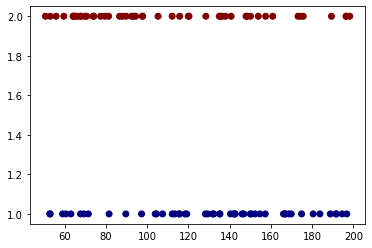

# Let's look at the data with axis "equal"

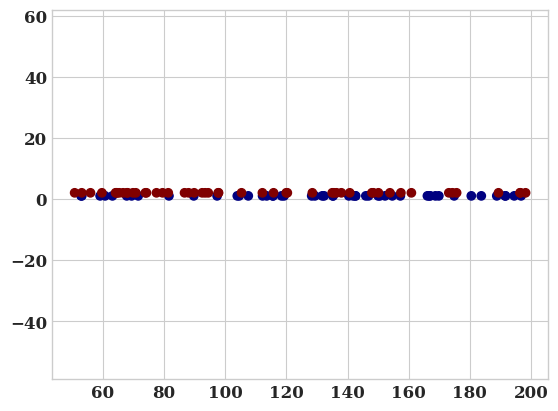

In [14]:
# Plot also the training points
plt.scatter(
    x=X[...,0],
    y=X[...,1],
    c=labels,
    cmap='jet',
);
plt.axis('equal');

# The previous decision boundary is really non-sense
- Feature on **first axis** has **no label information**, but its scale is **large**
- Feature on **second axis**  **is discriminative** but its scale is **small**

**The large scale** of irrelevant feature dominates in the distance computation.

# Feature 1 (on the x-axis of the plot) 

Values around ~150

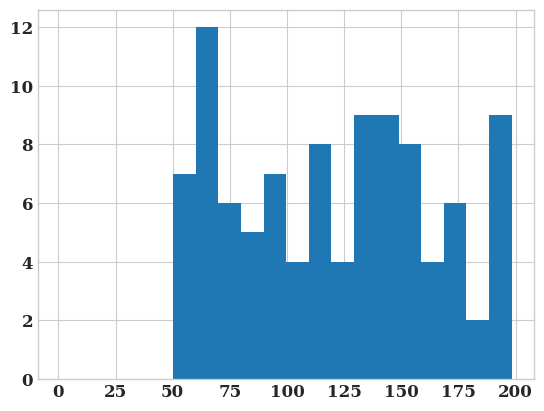

In [15]:
_ = plt.hist(X[..., 0], bins=20, range=(X.min(), X.max()))

# Feature 2 (on the y-axis of the plot) 

Values around 0 and 2

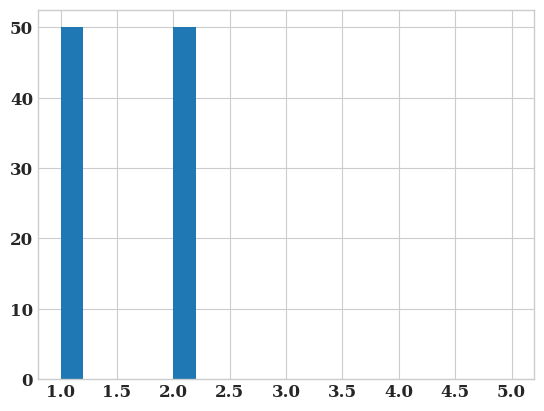

In [16]:
_ = plt.hist(X[..., 1], bins=20, range=(X.min(),5))

# Idea: Normalize features to be on the same scale

# Min-Max Normalization

$ \forall~ \text{dimension}$, **linearly** scales the features to be in the range $[0,1]$

$$ \bx^{\prime} = \frac{\bx - \bx_{\min}}{\bx_{\max} - \bx_{\min}}$$

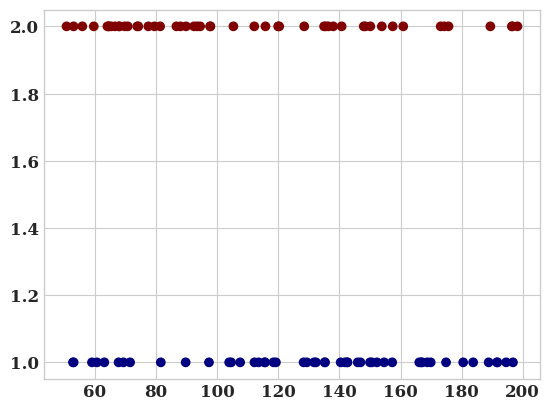

In [17]:
# Plot also the training points
plt.scatter(
    x=X[:, 0],
    y=X[:, 1],
    c=labels,
    cmap='jet',
)
# MinMax Normalization
maxX, minX = X.max(axis=0), X.min(axis=0)
X_old = np.copy(X)
X = (X - minX)/(maxX - minX)

# After (Focus on the  Axis range)

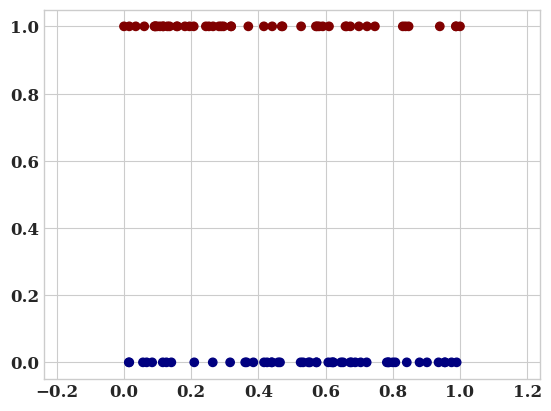

In [18]:
_=plt.scatter(x=X[:, 0],y=X[:, 1],c=labels, cmap='jet');plt.axis('equal');

/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


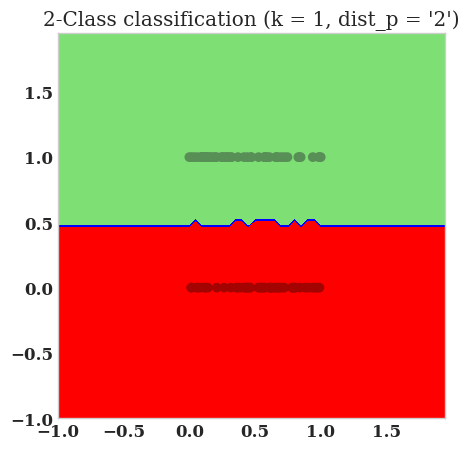

In [19]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

###################################################
h = 0.05  # step size in the mesh
n_neighbors = 1
##################################################

# Create color maps
cm = ListedColormap(["#a30401", "#0495dd", "#588f56"])
cm_bright = ListedColormap(["#FF0000", "#0000FF", "#7ddf74"])


for dist in [2]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(
        n_neighbors, weights="uniform", algorithm='brute', p=dist)
    clf.fit(X, labels)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, Z, cmap=cm_bright)

    # Plot also the training points
    plt.scatter(
        x=X[:, 0],
        y=X[:, 1],
        c=labels,
        cmap=cm,
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "2-Class classification (k = %i, dist_p = '%i')" % (n_neighbors, dist)
    )
plt.show()

/opt/miniconda3/envs/corso_py38/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


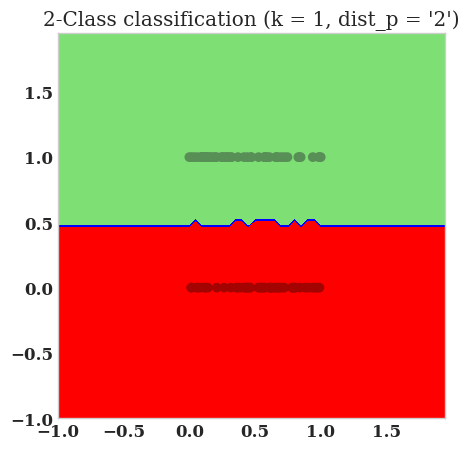

In [20]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

###################################################
h = 0.05  # step size in the mesh
n_neighbors = 1
##################################################

# Create color maps
cm = ListedColormap(["#a30401", "#0495dd", "#588f56"])
cm_bright = ListedColormap(["#FF0000", "#0000FF", "#7ddf74"])


for dist in [2]:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(
        n_neighbors, weights="uniform", algorithm='brute', p=dist)
    clf.fit(X, labels)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, Z, cmap=cm_bright)

    # Plot also the training points
    plt.scatter(
        x=X[:, 0],
        y=X[:, 1],
        c=labels,
        cmap=cm,
    )
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(
        "2-Class classification (k = %i, dist_p = '%i')" % (n_neighbors, dist)
    )
plt.show()

# Now I like it much more! Split along 0.5 on feature 2!

# Take-away: decision boundaries give you a way to assess learning


## Very Fragmented decision boundaries $\rightarrow$ probably overfit, model too specific

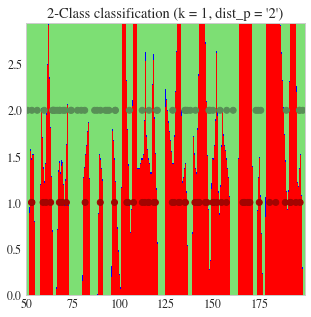

## Regular decision boundaries $\rightarrow$ probably underfit, model too generic.
## In this case is a good solution since problem was easy.

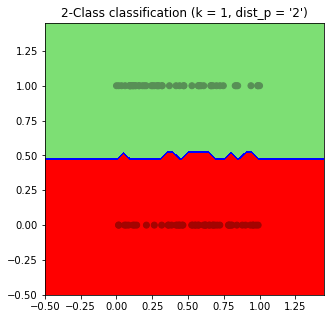

## Standardization

- Assumption that $\mathbf{X}$ is sampled from multi-variate Gaussian distribution
- **Center all the data in the center (origin)**. **Compute the mean and remove it.**
- **Rescale all axes so that the standard deviation is one.**

$$ \mathbf{X}^{\prime} \leftarrow \frac{\mathbf{X} - \mathbf{\mu}}{\mathbf{\sigma}} $$

# Feature Normalization in High-Dimensional Space $D\gg1$

- Feature normalization does not help in high-dimensional spaces if **most features are irrelevant**
- Assume that the dimensions (axis) are split into two sets: those of **irrelevant features** $\mathcal{S}_{ir}$ and those of **good features** $\mathcal{S}_{gd}$.
- $D = \mid\mathcal{S}_{ir}\mid + \mid\mathcal{S}_{gd}\mid$
- if $\mid\mathcal{S}_{ir}\mid \gg \mid\mathcal{S}_{gd}\mid$, then **we have problems with k-NN**

$$ d(\bx,\bv) = \sqrt{\sum_{i\in \mathcal{S}_{ir}}  \underbrace{(x_i - v_i)^2}_{\text{dominate}} + \sum_{j\in \mathcal{S}_{gd}}  \underbrace{(x_j - v_j)^2}_{\text{good yet not used}} } \qquad \text{with}~~\bx,\bv \in \mathbb{R}^D$$
- Eliminate some features or learn which features are important (**Metric Learning**)

# Feature Weighting

We can try to learn a vector  $\mbf{w} = [w_1,\ldots,w_D]$ that scales each dimension in the Euclidean distance. 
$$ d(\bx,\bv) = \sqrt{\sum_{i=1}^D  w_i(x_i - v_i)^2} \qquad \text{with}~~\bx,\bv \in \mathbb{R}^D$$

- Can use our prior knowledge about which features are more important
- Can learn the weights  $w_i$ using cross-validation (to be covered later)

## Note: `sklearn` offers off-the-shelf normalization with the class `StandardScaler()`
## Do not reinvent the wheel

# $k$-NN and data embedded in a High Dimensional Space

# $k$-NN and data embedded in a High Dimensional Space

- In high-dimension, points are concentrated at the **boundary of the space (hypercube)**
- If the entire space is the **Unit Hyper-cube** points will probably be at the edge. Why?
####  What is the probability of a point to be lie in the center of 1 dimension?

```
| eps | ------------- | eps |
0                           1
        length = 1
```
- Assuming points are sampled uniformly, prob. to be at the center is $p = (1-2\epsilon)$
- So if $\epsilon$ is small $p\approx0.9$. In 1-D, for sure it is at the center.

# $k$-NN and data embedded in a High Dimensional Space

- In high-dimension, points are concentrated at the **boundary of the space.**
- If the entire space is the **Unit Hyper-cube** points will probably be at the edge. Why?
####  What is the probability of a point to lie in the center in 2 dimensions?

```
0,0                          1,0
| eps | ------------- | eps |
|                           |
|                           |         
|                           |
|                           |
|                           |
|                           |
| eps | ------------- | eps |
0,1        length = 1          1,1
```
- Assuming points are sampled uniformly, prob. to be at the center is $p = (1-2\epsilon)^2$
- So if $\epsilon$ is small $p\approx0.81$. In 2-D, $p$ decreases.

# $k$-NN and data embedded in a High Dimensional Space

- In high-dimension, points are concentrated at the **boundary of the space.**
- If the entire space is the **Unit Hyper-cube** points will probably be at the edge. Why?
####  What is the probability of a point to lie in the center in 128 dimensions?

$p = (1-2\epsilon)^{128}$ = 0.9^128 = 0.000001390084524

# If most of the points are at the boundaries, how can $k$-NN work?

## Are we doomed?

# Recall: High-dimensional data may live on a subspace or manifold

<img width="50%" src="figs/manifold.png" />

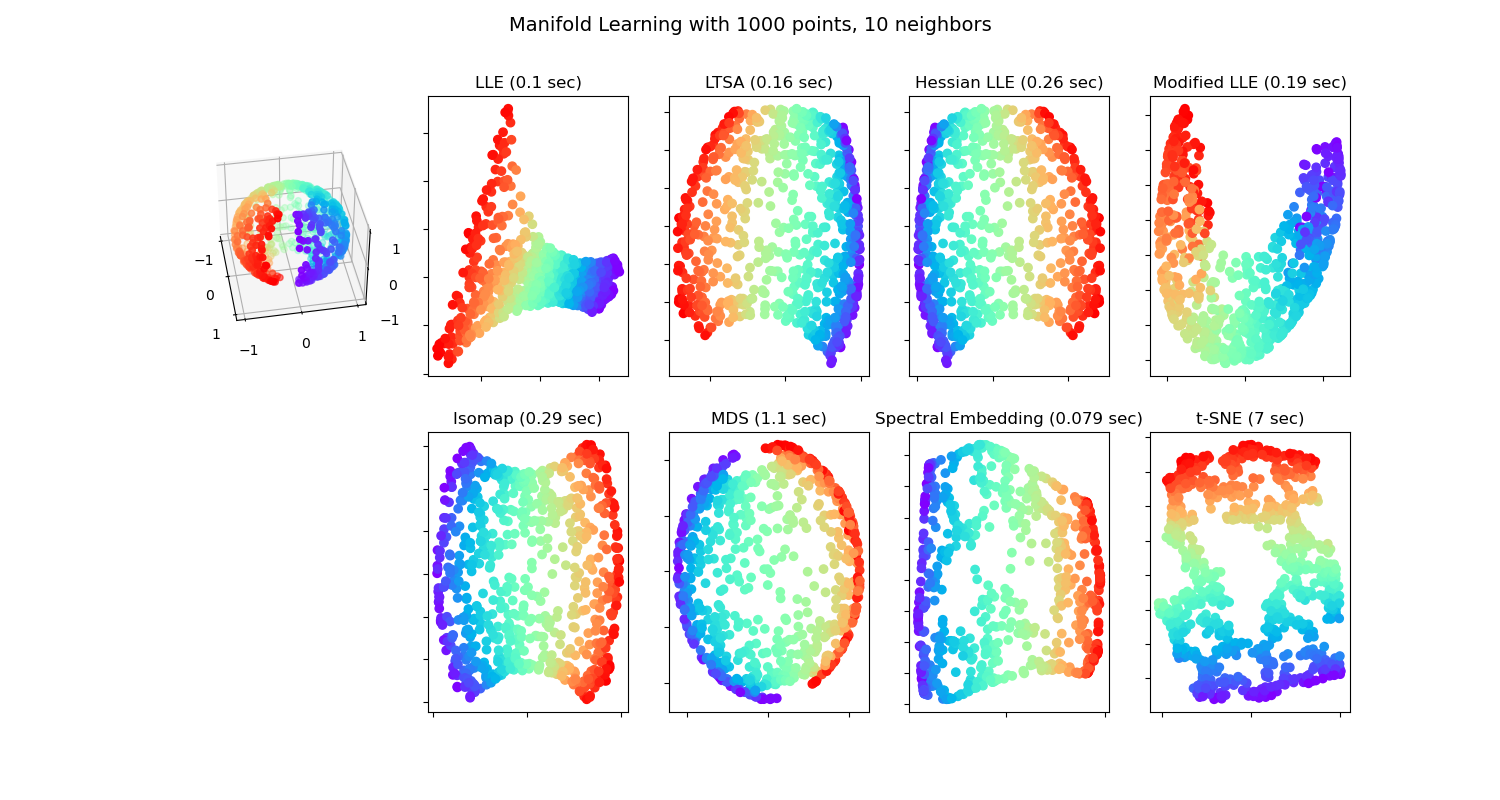

# Wrap-up of $k$-NN

## Complexity
Suppose we have $N$ examples each of dimension $D$:
- $\mathcal{O}(D)$ to compute distance to one examples
- $\mathcal{O}(ND)$ to compute distances to all examples
- Plus time to find $k$ closest examples

**Trade-off:**
- Very expensive for a large number of samples
- But we need a large number of samples for kNN to work well!

# Reducing Complexity

Various exact and approximate methods for reducing complexity:
- Reduce the dimensionality of the data (Feature Removal with cross-validation)
- Find projection to a lower dimensional space so that the distances between samples are approximated
- Use advanced data structures for fast search such as **K-D trees** and perform **ANN** (Approximate NN).

# Advantages of $k$-NN

- **[Key assumptions] The output varies smoothly wrt the input**
- Can be applied to the data from any distribution **(even multi-modal):**
- **Complex** decision boundaries that adapt to data density
- Very simple and intuitive
- Good classification if the number of samples is large enough

# Disadvantages of $k$-NN


- Sensitive to label noise (Sol: smoothing)
- Sensitive to scales of attributes (sol: feature norm)
- Distances are less meaningful in high dimensions
- Scales linearly with many examples

# Validation set or development set

Ok, we train on `train` split and we test on `test` split.

**How do we select the distance and $k$ neighbours?**

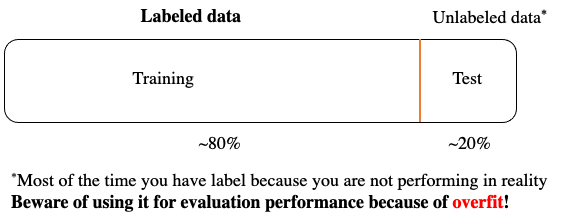

Ok we train on `train` split and we test on `test` split.

**How do we select the distance and $k$ neighbours?**

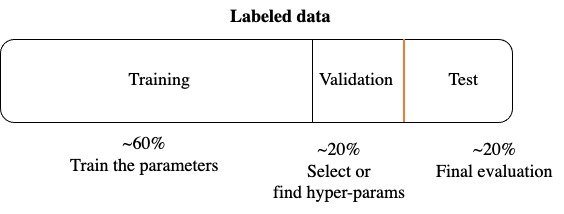